# NLP Transformer: Inference

In [ ]:
!pip install Wikidata
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 31.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 8.9 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system ==

In [ ]:
import torch, random, requests, os, pickle
import numpy as np
from wikidata.client import Client
from datasets import load_dataset
import pandas as pd
from google.colab import userdata
from google.colab import drive
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

In [ ]:
from transformers import set_seed

Setting seeds to try to make the training as much deterministic as possible.
This should help to compare results (for the instance accuracy of the validation test) of different trainings.

In [ ]:
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

In [ ]:
set_seed(42)

Wikipedia pages and Wikidata data need to be loaded from the web.
In order to speed up the training and the inference processes, we store (cache) the retrieved and the processed data into .bin files

In [ ]:
drive.mount('/content/drive')
BASE_PATH = '/content/drive/MyDrive/Lost_in_Language_Recognition/'

def dump(file_name, result):
    file_path = BASE_PATH + file_name
    # remove dump files if present
    if os.path.exists(file_path):
        os.remove(file_path)
    with open(file_path, 'wb') as file:
        print("dumping", file_path)
        # noinspection PyTypeChecker
        pickle.dump(result, file)

def load(file_name):
    file_path = BASE_PATH + file_name
    with open(file_path, 'rb') as file:
        print("loading", file_path)
        # noinspection PyTypeChecker
        return pickle.load(file)

def file_exists(file_name):
    file_path = BASE_PATH + file_name
    return os.path.exists(file_path)

Mounted at /content/drive


In this section we build the singleton `NLPDataset`, that contains:
1. The original Hugging Face dataset
2. The Wikidata entities
3. The Wikipedia pages

In [ ]:
def wikipedia_pages(sitelinks):
    result = []
    for site_key in sitelinks.keys():
        if site_key.endswith("wiki") and not site_key.startswith("commons"):
            lang = site_key.replace("wiki", "")
            result.append(lang)
    return result

def build_claims(claims):
    result = {}
    for prop_id, values in claims.items():
        result[prop_id] = len(values)
    return result

class Entity:
    def __init__(self, entity_id, dataset_item, wiki_data, wiki_text):
        self.entity_id = entity_id
        if 'label' in dataset_item:
            self.label = dataset_item['label']
        self.name = dataset_item['name']
        self.description = dataset_item['description']
        self.type = dataset_item['type']
        self.category = dataset_item['category']
        self.subcategory = dataset_item['subcategory']
        self.wiki_text = wiki_text
        # Languages
        self.labels = list(wiki_data.data.get("labels", {}).keys())
        self.descriptions = list(wiki_data.data.get("descriptions", {}).keys())
        self.aliases = list(wiki_data.data.get("aliases", {}).keys())
        self.wikipedia_pages = wikipedia_pages(wiki_data.data.get("sitelinks", {}))
        # Properties
        self.claims = build_claims(wiki_data.data.get("claims", {}))

    def __str__(self):
        return self.entity_id + ": " + self.label + " - " + self.name

API_URL = "https://en.wikipedia.org/w/api.php"

def extract_entity_id(url):
    return url.strip().split("/")[-1]

def get_wiki_text(en_wiki):
    if not en_wiki:
        return None
    title = en_wiki["title"]
    params = {
        "action": "query",
        "prop": "extracts",
        "explaintext": True,
        "titles": title,
        "format": "json",
        "redirects": 1
    }
    headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 6.2; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/75.0.3770.100 Safari/537.36'}
    res = requests.get(API_URL, params=params, headers=headers)
    json = res.json()
    page = next(iter(json["query"]["pages"].values()))
    # Keep the original text as it is.
    # The text will be processed in other methods,
    # such as processed_dataset#tokenize().
    return page.get("extract", "")

class EntityFactory:
    def __init__(self, client):
        self.client = client

    def create(self, item):
        entity_id = extract_entity_id(item['item'])
        try:
            wikidata = self.client.get(entity_id, load=True)
            sitelinks = wikidata.data.get("sitelinks", {})
            en_wiki = sitelinks.get("enwiki")
            return Entity(entity_id, item, wikidata, get_wiki_text(en_wiki))
        except Exception as e:
            print("Error loading id:", entity_id, e)
            return None

TEST_SET_FILE_NAME = BASE_PATH + "test_unlabeled.csv"

TRAINING_FILE_NAME = "training.bin"
VALIDATION_FILE_NAME = "validation.bin"
TEST_FILE_NAME = "test.bin"

def create_set(dataset, factory, file_name):
    limit = len(dataset)
    result = []
    for index, item in enumerate(dataset):
        created = factory.create(item)
        if created is not None:
            result.append(created)
        if (index + 1) % 10 == 0:
            print("creating", file_name, index + 1, "/", limit)
    return result

def load_or_create_set(factory, dataset, file_name):
    if not (file_exists(file_name)):
        created = create_set(dataset, factory, file_name)
        dump(file_name, created)
        return created
    else:
        return load(file_name)

class NLPDataset:
    def __init__(self):
        if (not (file_exists(TRAINING_FILE_NAME)) or not (file_exists(VALIDATION_FILE_NAME))
                or not (file_exists(TEST_FILE_NAME))):
            # load the project dataset
            dataset = load_dataset('sapienzanlp/nlp2025_hw1_cultural_dataset', token=userdata.get('HF_TOKEN'))
            # a factory object is used to create our entities
            factory = EntityFactory(Client())

            self.training_set = load_or_create_set(factory, dataset['train'], TRAINING_FILE_NAME)
            self.validation_set = load_or_create_set(factory, dataset['validation'], VALIDATION_FILE_NAME)
            self.test_set = load_or_create_set(factory, pd.read_csv(TEST_SET_FILE_NAME).to_dict('records'), TEST_FILE_NAME)
        else:
            # by default load the dataset from a local dump
            self.training_set = load(TRAINING_FILE_NAME)
            self.validation_set = load(VALIDATION_FILE_NAME)
            self.test_set = load(TEST_FILE_NAME)

    def __str__(self):
        return ("training: " + str(len(self.training_set)) + ". validation: " + str(len(self.validation_set)) +
                ". test: " + str(len(self.test_set)))

In [ ]:
nlp_dataset = NLPDataset()

loading /content/drive/MyDrive/Lost_in_Language_Recognition/training.bin
loading /content/drive/MyDrive/Lost_in_Language_Recognition/validation.bin
loading /content/drive/MyDrive/Lost_in_Language_Recognition/test.bin


If the dump files `training.bin` and `validation.bin` are present, the instance is build from the dump.
And this is all we need to use the transformer. That is, usually with transformers we don't need to process the data.

In [ ]:
import csv
from transformers import AutoModelForSequenceClassification, AutoTokenizer

In this case we will keep the description and the Wikipedia page text as they are, leaving the burden of taking text processing decisions to the tokenizer. The dataset here is enriched with the Wikipedia text and the labels are mapped to numbers:

In this colab we reuse the result produced by the other colab: `NLP_yes_transformer_training.ipynb`. The model is used to predict the label of the validation set.

In [ ]:
class InferenceModel:
    def __init__(self, repo, kind):
        self.model = AutoModelForSequenceClassification.from_pretrained(repo)
        self.tokenizer = AutoTokenizer.from_pretrained(kind)
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.model.to(self.device)

    def predict(self, desc, wiki):
        self.model.eval()
        # no max length - we want to use the default of the base model
        # as we do in training
        encoding = self.tokenizer(desc, wiki, return_tensors='pt', padding='max_length', truncation=True)
        input_ids = encoding['input_ids'].to(self.device)
        attention_mask = encoding['attention_mask'].to(self.device)
        with torch.no_grad():
            outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
            _, prediction = torch.max(outputs.logits, dim=1)
        return prediction.item()

Finally, the inference code. The output is also stored in a csv file: `transformer-inference.csv`. So that this can be inspected later.

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

inference of the validation set:  10 / 300
matched 8 on 10 ( 0.8 )
inference of the validation set:  20 / 300
matched 17 on 20 ( 0.85 )
inference of the validation set:  30 / 300
matched 22 on 30 ( 0.7333333333333333 )
inference of the validation set:  40 / 300
matched 28 on 40 ( 0.7 )
inference of the validation set:  50 / 300
matched 37 on 50 ( 0.74 )
inference of the validation set:  60 / 300
matched 45 on 60 ( 0.75 )
inference of the validation set:  70 / 300
matched 54 on 70 ( 0.7714285714285715 )
inference of the validation set:  80 / 300
matched 63 on 80 ( 0.7875 )
inference of the validation set:  90 / 300
matched 71 on 90 ( 0.7888888888888889 )
inference of the validation set:  100 / 300
matched 78 on 100 ( 0.78 )
inference of the validation set:  110 / 300
matched 86 on 110 ( 0.7818181818181819 )
inference of the validation set:  120 / 300
matched 94 on 120 ( 0.7833333333333333 )
inference of the validation set:  130 / 300
matched 102 on 130 ( 0.7846153846153846 )
inference o

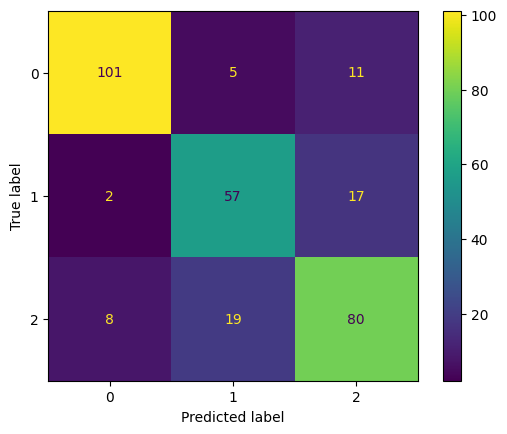

In [ ]:
def number_to_label(label):
    if label == 0:
        return 'cultural agnostic'
    if label == 1:
        return 'cultural representative'
    if label == 2:
        return 'cultural exclusive'
    raise ValueError('label not suppoerted: ' + label)

model = InferenceModel("fax4ever/culturalitems-roberta-base", "roberta-base")

matching = 0
predictions = []
labels = []
for index, item in enumerate(nlp_dataset.validation_set):
    prediction = model.predict(item.description, item.wiki_text)
    predicted_label = number_to_label(prediction)
    predictions.append(predicted_label)
    labels.append(item.label)
    match = predicted_label == item.label
    if match:
        matching = matching + 1
    if (index + 1) % 10 == 0:
        print('inference of the validation set: ', index + 1, "/", len(nlp_dataset.validation_set))
        print('matched', matching, 'on', index + 1, '(', matching / (index + 1), ')')
print('inference of the validation: completed')
print('matched', matching, 'on', len(nlp_dataset.validation_set), '(', matching / len(nlp_dataset.validation_set), ')')

cm = confusion_matrix(labels, predictions)
ConfusionMatrixDisplay(cm).plot()
print('f1', f1_score(labels, predictions, average='macro'))
print('recall', recall_score(labels, predictions, average='macro'))
print('precision', precision_score(labels, predictions, average='macro'))
print('accuracy_score', accuracy_score(labels, predictions))

with open(BASE_PATH + 'Lost_in_Language_Recognition_output_roberta.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    field = ['item', 'name', 'label']
    writer.writerow(field)
    for index, item in enumerate(nlp_dataset.test_set):
        prediction = model.predict(item.description, item.wiki_text)
        writer.writerow(["http://www.wikidata.org/entity/" + item.entity_id, item.name, number_to_label(prediction)])
        if (index + 1) % 10 == 0:
            print('inference of the test set: ', index + 1, "/", len(nlp_dataset.test_set))
    print('inference of the test set: completed')